In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE

##  Data processing：

In [9]:

file_path = 'diabetes_scale.txt'

# 使用 load_svmlight_file 加载 LIBSVM 格式的数据
data, labels = load_svmlight_file(file_path)

# 定义特征名称
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# 将稀疏矩阵转换为 DataFrame，并添加特征和标签列
df = pd.DataFrame(data.toarray(), columns=column_names)
df['Label'] = labels

# 将 -1 标签转换为 0，适合二分类任务
df['Label'] = df['Label'].replace(-1, 0)

# 查看数据集基本信息
print(df.head())

label_counts = df['Label'].value_counts()
print(label_counts)

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0    -0.294118  0.487437       0.180328      -0.292929 -1.000000  0.001490   
1    -0.882353 -0.145729       0.081967      -0.414141 -1.000000 -0.207153   
2    -0.058824  0.839196       0.049180      -1.000000 -1.000000 -0.305514   
3    -0.882353 -0.105528       0.081967      -0.535354 -0.777778 -0.162444   
4    -1.000000  0.376884      -0.344262      -0.292929 -0.602837  0.284650   

   DiabetesPedigreeFunction       Age  Label  
0                 -0.531170 -0.033333    0.0  
1                 -0.766866 -0.666667    1.0  
2                 -0.492741 -0.633333    0.0  
3                 -0.923997 -1.000000    1.0  
4                  0.887276 -0.600000    0.0  
Label
1.0    500
0.0    268
Name: count, dtype: int64


In [11]:
# 1. Check for missing values
print("Are there any missing values:")
print(df.isnull().sum())  # Display the number of missing values in each feature

print("Original shape:")
print(df.shape)


Are there any missing values:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Label                       0
dtype: int64
Original shape:
(768, 9)


Plotting boxplot to detect outliers:


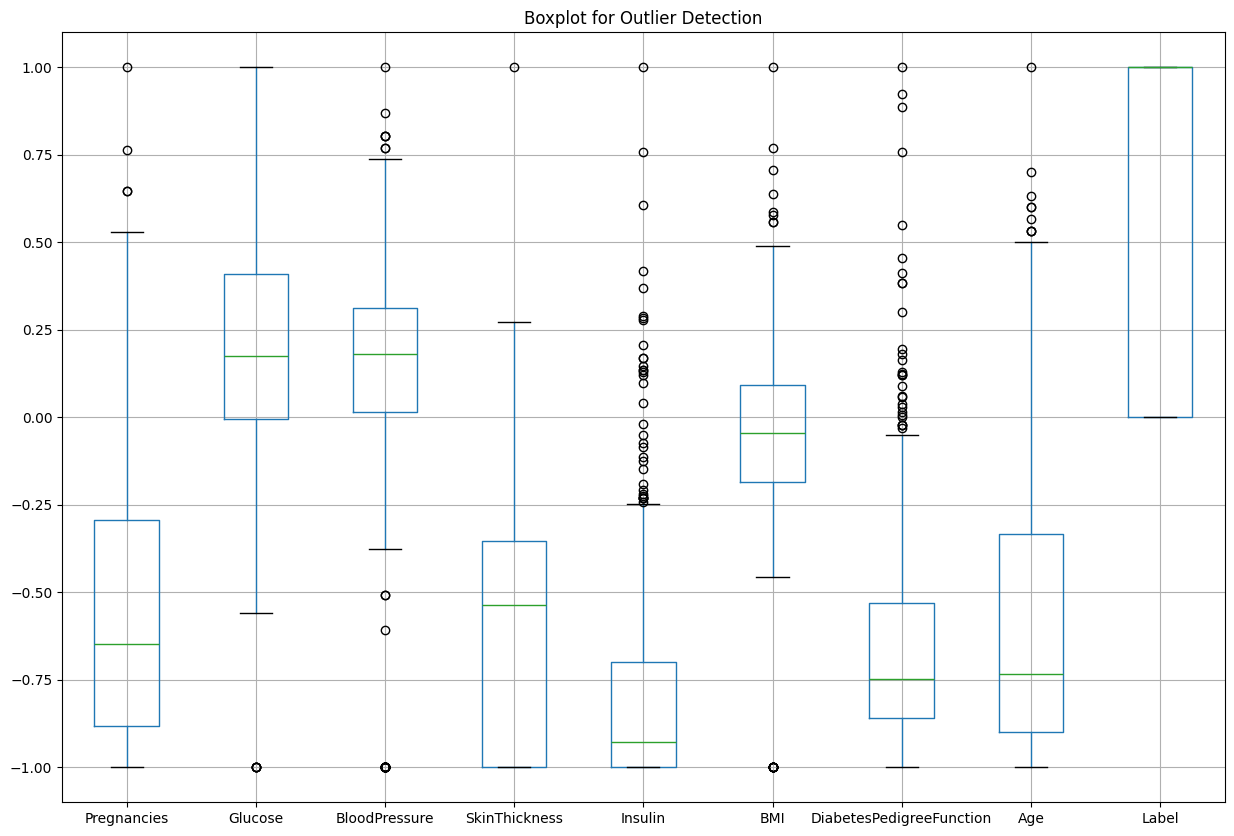

After outlier removal:
(652, 9)
Label
1.0    446
0.0    206
Name: count, dtype: int64


In [12]:
# Check for outliers (by plotting a boxplot)
print("Plotting boxplot to detect outliers:")
df.boxplot(figsize=(15, 10))
plt.title("Boxplot for Outlier Detection")
plt.show()

# Remove outliers
def remove_outliers(df, column_names):
    for col in column_names:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Remove outliers outside the lower and upper bounds
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# Remove outliers for the specified features
df_cleaned = remove_outliers(df, ['Glucose', 'BloodPressure', 'SkinThickness', 
                                  'Insulin', 'BMI', 'DiabetesPedigreeFunction'])

print("After outlier removal:")
print(df_cleaned.shape)

clean_counts = df_cleaned['Label'].value_counts()
print(clean_counts)

Skewness of features:
Pregnancies                 0.912059
Glucose                     0.578735
BloodPressure               0.096018
SkinThickness              -0.077920
Insulin                     1.094324
BMI                         0.252330
DiabetesPedigreeFunction    0.901094
Age                         1.118128
Label                      -0.793617
dtype: float64


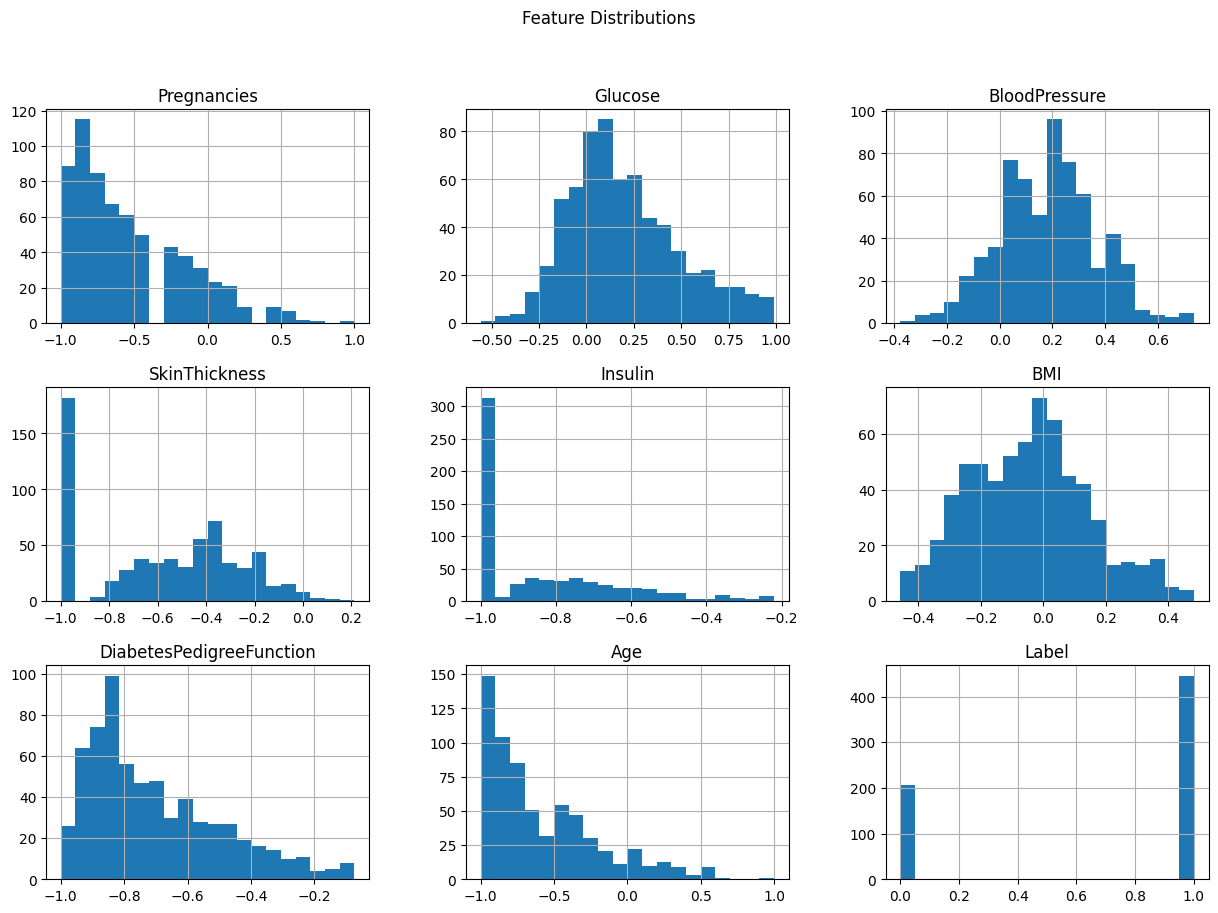

In [5]:
skewed_features = df_cleaned.skew()
print("Skewness of features:")
print(skewed_features)

df_cleaned.hist(bins=20, figsize=(15, 10))
plt.suptitle("Feature Distributions")
plt.show()

### Feature Scaling and Dataset Splitting

In [6]:

# 数据分离（分离特征和标签）
X = df_cleaned.drop('Label', axis=1).values  # 特征
y = df_cleaned['Label'].values  # 标签
print(X)

# 数据标准化
scaler = StandardScaler() #均值为0，标准差为1
X = scaler.fit_transform(X)

# 数据集划分（80%训练集，20%测试集）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用 SMOTE 上采样少数类
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# 输出数据集的形状
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

[[-0.294118    0.487437    0.180328   ...  0.00149028 -0.53117
  -0.0333333 ]
 [-0.882353   -0.145729    0.0819672  ... -0.207153   -0.766866
  -0.666667  ]
 [-0.0588235   0.839196    0.0491803  ... -0.305514   -0.492741
  -0.633333  ]
 ...
 [-0.411765    0.21608     0.180328   ... -0.219076   -0.857387
  -0.7       ]
 [-0.882353    0.266332   -0.0163934  ... -0.102832   -0.768574
  -0.133333  ]
 [-0.882353   -0.0653266   0.147541   ... -0.0938897  -0.797609
  -0.933333  ]]
Training set shape: (456, 8), Test set shape: (196, 8)


## Model 

### Dataset

In [7]:
# 定义自定义 Dataset 类
class DiabetesDataset(Dataset):
    def __init__(self, data, labels):
        self.X = torch.tensor(data, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# 创建 Dataset 对象
train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


### MLP model

In [8]:
import torch
import torch.nn as nn

# 定义MLP模型，支持不同的深度和隐藏层神经元数
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_hidden_layers=1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()

        # 动态添加隐藏层
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden_layers - 1)])
        
        # 输出层
        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        
        for layer in self.hidden_layers:
            out = layer(out)
            out = self.relu(out)
        
        out = self.fc_out(out)
        return out

### Trainning model

In [9]:
import torch.optim as optim
import numpy as np
import random
import torch.nn.functional as F
# 设置随机种子函数
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 训练模型


        
def train_model(train_loader, input_size, num_classes, hidden_size, num_hidden_layers, learning_rate, num_epochs=100, random_seed=42):
    # 设置随机种子
    set_random_seed(random_seed)

    # 初始化模型、优化器和损失函数
    model = MLP(input_size, hidden_size, num_classes, num_hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model  # 返回训练好的模型

### Evaluate model

In [10]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# 评估函数，计算准确率、精度、召回率、F1分数、AUC 和混淆矩阵
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_prob = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_prob.extend(torch.softmax(outputs, dim=1)[:, 1].cpu().numpy())  # 用于AUC计算

    # 计算评估指标
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    conf_matrix = confusion_matrix(y_true, y_pred)

    return accuracy, precision, recall, f1, auc, conf_matrix

### Best Paremeter

In [11]:
# 超参数组合
depths = [1, 3, 5]  # MLP的深度，隐藏层的数量
hidden_sizes = [32, 64, 128]  # 每层隐藏层的神经元数量
learning_rates = [0.00001, 0.00005, 0.0001]  # 学习率
random_seed =42
# 假设输入数据有 8 个特征，二分类任务
input_size = 8  # 输入层的大小，特征数量
num_classes = 2  # 类别数量，二分类任务
num_epochs = 100  # 训练的轮次

# 假设你有 train_loader 和 test_loader 作为数据加载器
# train_loader, test_loader = 你的数据加载器

# 初始化变量
best_result = None
best_hyperparams = {}

# 超参数搜索
for depth in depths:
    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            print(f"Training with Depth={depth}, Hidden Size={hidden_size}, Learning Rate={lr}")
            model = train_model(train_loader, input_size, num_classes, hidden_size, depth, lr, num_epochs, random_seed=random_seed)
            accuracy, precision, recall, f1, auc, conf_matrix = evaluate_model(model, test_loader)
            
            result = {
                'Depth': depth,
                'Hidden Size': hidden_size,
                'Learning Rate': lr,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC': auc,
                'Confusion Matrix': conf_matrix
            }

            # 比较AUC，找到最佳模型
            if best_result is None or result['F1 Score'] > best_result['F1 Score']:
                best_result = result
                best_hyperparams = {
                    'Depth': depth,
                    'Hidden Size': hidden_size,
                    'Learning Rate': lr
                }

# 打印最佳超参数和评估结果
print("\nBest Hyperparameter Combination:")
print(f"Depth: {best_hyperparams['Depth']}, Hidden Size: {best_hyperparams['Hidden Size']}, Learning Rate: {best_hyperparams['Learning Rate']}")
print("\nBest Evaluation Results:")
print(f"Accuracy: {best_result['Accuracy']:.4f}, Precision: {best_result['Precision']:.4f}, Recall: {best_result['Recall']:.4f}, F1 Score: {best_result['F1 Score']:.4f}, AUC: {best_result['AUC']:.4f}")
print("Confusion Matrix:")
print(best_result['Confusion Matrix'])

Training with Depth=1, Hidden Size=32, Learning Rate=1e-05
Training with Depth=1, Hidden Size=32, Learning Rate=5e-05
Training with Depth=1, Hidden Size=32, Learning Rate=0.0001
Training with Depth=1, Hidden Size=64, Learning Rate=1e-05
Training with Depth=1, Hidden Size=64, Learning Rate=5e-05
Training with Depth=1, Hidden Size=64, Learning Rate=0.0001
Training with Depth=1, Hidden Size=128, Learning Rate=1e-05
Training with Depth=1, Hidden Size=128, Learning Rate=5e-05
Training with Depth=1, Hidden Size=128, Learning Rate=0.0001
Training with Depth=3, Hidden Size=32, Learning Rate=1e-05
Training with Depth=3, Hidden Size=32, Learning Rate=5e-05
Training with Depth=3, Hidden Size=32, Learning Rate=0.0001
Training with Depth=3, Hidden Size=64, Learning Rate=1e-05
Training with Depth=3, Hidden Size=64, Learning Rate=5e-05
Training with Depth=3, Hidden Size=64, Learning Rate=0.0001
Training with Depth=3, Hidden Size=128, Learning Rate=1e-05
Training with Depth=3, Hidden Size=128, Learnin

In [12]:
# 超参数搜索
for depth in depths:
    for hidden_size in hidden_sizes:
        for lr in learning_rates:
            print(f"\nTraining with Depth={depth}, Hidden Size={hidden_size}, Learning Rate={lr}")
            model = train_model(train_loader, input_size, num_classes, hidden_size, depth, lr, num_epochs, random_seed=random_seed)
            accuracy, precision, recall, f1, auc, conf_matrix = evaluate_model(model, test_loader)
            
            result = {
                'Depth': depth,
                'Hidden Size': hidden_size,
                'Learning Rate': lr,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1 Score': f1,
                'AUC': auc,
                'Confusion Matrix': conf_matrix
            }

            # 打印每个超参数组合的结果
            print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, AUC: {auc:.4f}")
            
            # 比较AUC，找到最佳模型
            if best_result is None or result['F1 Score'] > best_result['F1 Score']:
                best_result = result
                best_hyperparams = {
                    'Depth': depth,
                    'Hidden Size': hidden_size,
                    'Learning Rate': lr
                }

# 打印最佳超参数和评估结果
print("\nBest Hyperparameter Combination:")
print(f"Depth: {best_hyperparams['Depth']}, Hidden Size: {best_hyperparams['Hidden Size']}, Learning Rate: {best_hyperparams['Learning Rate']}")
print("\nBest Evaluation Results:")
print(f"Accuracy: {best_result['Accuracy']:.4f}, Precision: {best_result['Precision']:.4f}, Recall: {best_result['Recall']:.4f}, F1 Score: {best_result['F1 Score']:.4f}, AUC: {best_result['AUC']:.4f}")
print("Confusion Matrix:")
print(best_result['Confusion Matrix'])


Training with Depth=1, Hidden Size=32, Learning Rate=1e-05
Accuracy: 0.5663, Precision: 0.8966, Recall: 0.3969, F1 Score: 0.5503, AUC: 0.7334

Training with Depth=1, Hidden Size=32, Learning Rate=5e-05
Accuracy: 0.7449, Precision: 0.7956, Recall: 0.8321, F1 Score: 0.8134, AUC: 0.7859

Training with Depth=1, Hidden Size=32, Learning Rate=0.0001
Accuracy: 0.7500, Precision: 0.7595, Recall: 0.9160, F1 Score: 0.8304, AUC: 0.8130

Training with Depth=1, Hidden Size=64, Learning Rate=1e-05
Accuracy: 0.7245, Precision: 0.7984, Recall: 0.7863, F1 Score: 0.7923, AUC: 0.7450

Training with Depth=1, Hidden Size=64, Learning Rate=5e-05
Accuracy: 0.7398, Precision: 0.7532, Recall: 0.9084, F1 Score: 0.8235, AUC: 0.8019

Training with Depth=1, Hidden Size=64, Learning Rate=0.0001
Accuracy: 0.7755, Precision: 0.7736, Recall: 0.9389, F1 Score: 0.8483, AUC: 0.8311

Training with Depth=1, Hidden Size=128, Learning Rate=1e-05
Accuracy: 0.7194, Precision: 0.7568, Recall: 0.8550, F1 Score: 0.8029, AUC: 0.7

## KNN, Perceptron

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define custom Dataset class
class DiabetesDataset(Dataset):
    def __init__(self, data, labels):
        self.X = torch.tensor(data, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Evaluation function to calculate accuracy, precision, recall, F1 score, AUC, and confusion matrix
def evaluate_baseline_model(y_true, y_pred, y_prob):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    conf_matrix = confusion_matrix(y_true, y_pred)
    return accuracy, precision, recall, f1, auc, conf_matrix

# Train and evaluate Perceptron model
def train_perceptron(X_train, y_train, X_test, y_test):
    model = Perceptron()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.decision_function(X_test)
    return evaluate_baseline_model(y_test, y_pred, y_prob)

# Train and evaluate KNN model
def train_knn(X_train, y_train, X_test, y_test, n_neighbors=5):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return evaluate_baseline_model(y_test, y_pred, y_pred)  # KNN does not output probabilities, use y_pred as y_prob

# Convert DataLoader to NumPy arrays
def convert_to_numpy(loader):
    X = []
    y = []
    for inputs, labels in loader:
        X.append(inputs.numpy())
        y.append(labels.numpy())
    X = np.concatenate(X)
    y = np.concatenate(y)
    return X, y

# Create Dataset and DataLoader
train_dataset = DiabetesDataset(X_train, y_train)
test_dataset = DiabetesDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

# Convert data to NumPy format
X_train_np, y_train_np = convert_to_numpy(train_loader)
X_test_np, y_test_np = convert_to_numpy(test_loader)

# 6. Train and evaluate Perceptron model
perceptron_results = train_perceptron(X_train_np, y_train_np, X_test_np, y_test_np)
print("Perceptron results:", perceptron_results)

# 7. Train and evaluate KNN model
knn_results = train_knn(X_train_np, y_train_np, X_test_np, y_test_np, n_neighbors=5)
print("KNN results:", knn_results)



Perceptron results: (0.7091836734693877, np.float64(0.7681159420289855), np.float64(0.8091603053435115), np.float64(0.7881040892193308), np.float64(0.7732237228420434), array([[ 33,  32],
       [ 25, 106]]))
KNN results: (0.7653061224489796, np.float64(0.785234899328859), np.float64(0.8931297709923665), np.float64(0.8357142857142857), np.float64(0.7004110393423371), array([[ 33,  32],
       [ 14, 117]]))


### comparison of perceptron, knn, mlp

In [14]:
# Comparison of Perceptron, KNN, and MLP
comparison_df = pd.DataFrame({
    'Model': ['MLP (Best)', 'Perceptron', 'KNN'],
    'Accuracy': [best_result['Accuracy'], perceptron_results[0], knn_results[0]],
    'Precision': [best_result['Precision'], perceptron_results[1], knn_results[1]],
    'Recall': [best_result['Recall'], perceptron_results[2], knn_results[2]],
    'F1': [best_result['F1 Score'], perceptron_results[3], knn_results[3]],
    'AUC': [best_result['AUC'], perceptron_results[4], knn_results[4]]
})

# 保留4位小数并输出表格
comparison_df = comparison_df.round(4)
print(comparison_df)
comparison_df.to_csv('model_performance_comparison.csv', index=False)

        Model  Accuracy  Precision  Recall      F1     AUC
0  MLP (Best)    0.8061     0.8079  0.9313  0.8652  0.8602
1  Perceptron    0.7092     0.7681  0.8092  0.7881  0.7732
2         KNN    0.7653     0.7852  0.8931  0.8357  0.7004


# EDA

In [15]:
# 没有上采样的数据训练 MLP
print("Training MLP without upsampling:")
mlp_no_upsampling = train_model(train_loader, input_size, num_classes, best_hyperparams['Hidden Size'], best_hyperparams['Depth'], best_hyperparams['Learning Rate'])
accuracy_no_upsampling, precision_no_upsampling, recall_no_upsampling, f1_no_upsampling, auc_no_upsampling, _ = evaluate_model(mlp_no_upsampling, test_loader)

# 使用上采样的数据训练 MLP
train_dataset_resampled = DiabetesDataset(X_resampled, y_resampled)
train_loader_resampled = DataLoader(dataset=train_dataset_resampled, batch_size=128, shuffle=True)

print("Training MLP with upsampling:")
mlp_with_upsampling = train_model(train_loader_resampled, input_size, num_classes, best_hyperparams['Hidden Size'], best_hyperparams['Depth'], best_hyperparams['Learning Rate'])
accuracy_with_upsampling, precision_with_upsampling, recall_with_upsampling, f1_with_upsampling, auc_with_upsampling, _ = evaluate_model(mlp_with_upsampling, test_loader)

# 创建 DataFrame 对比结果
comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Without Upsampling': [accuracy_no_upsampling, precision_no_upsampling, recall_no_upsampling, f1_no_upsampling, auc_no_upsampling],
    'With Upsampling': [accuracy_with_upsampling, precision_with_upsampling, recall_with_upsampling, f1_with_upsampling, auc_with_upsampling]
})

# 保留4位小数
comparison_df = comparison_df.round(4)
print(comparison_df)

# 导出结果到 CSV
comparison_df.to_csv('upsampling_comparison_results.csv', index=False)

Training MLP without upsampling:
Training MLP with upsampling:
      Metric  Without Upsampling  With Upsampling
0   Accuracy              0.8061           0.7500
1  Precision              0.8079           0.8203
2     Recall              0.9313           0.8015
3   F1 Score              0.8652           0.8108
4        AUC              0.8602           0.8614


## Regularization

In [16]:
# 无正则化的MLP
print("Training MLP without regularization:")
mlp_no_regularization = train_model(train_loader, input_size, num_classes, best_hyperparams['Hidden Size'], best_hyperparams['Depth'], best_hyperparams['Learning Rate'])
accuracy_no_reg, precision_no_reg, recall_no_reg, f1_no_reg, auc_no_reg, _ = evaluate_model(mlp_no_regularization, test_loader)

# 有正则化的MLP (L2)
def train_model_with_regularization(train_loader, input_size, num_classes, hidden_size, num_hidden_layers, learning_rate, weight_decay=1e-4, num_epochs=100, random_seed=42):
    set_random_seed(random_seed)
    model = MLP(input_size, hidden_size, num_classes, num_hidden_layers)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # L2正则化
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model

print("Training MLP with regularization:")
mlp_with_regularization = train_model_with_regularization(train_loader, input_size, num_classes, best_hyperparams['Hidden Size'], best_hyperparams['Depth'], best_hyperparams['Learning Rate'])
accuracy_reg, precision_reg, recall_reg, f1_reg, auc_reg, _ = evaluate_model(mlp_with_regularization, test_loader)

# 对比结果
comparison_df_reg = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Without Regularization': [accuracy_no_reg, precision_no_reg, recall_no_reg, f1_no_reg, auc_no_reg],
    'With Regularization': [accuracy_reg, precision_reg, recall_reg, f1_reg, auc_reg]
})

# 保留4位小数并输出表格
comparison_df_reg = comparison_df_reg.round(4)
print(comparison_df_reg)

# 导出到CSV文件
comparison_df_reg.to_csv('regularization_comparison_results.csv', index=False)

Training MLP without regularization:
Training MLP with regularization:
      Metric  Without Regularization  With Regularization
0   Accuracy                  0.8061               0.8061
1  Precision                  0.8079               0.8079
2     Recall                  0.9313               0.9313
3   F1 Score                  0.8652               0.8652
4        AUC                  0.8602               0.8604
